<a href="https://colab.research.google.com/github/JoaoP29/abcia/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código baseado em: https://www.tensorflow.org/tutorials/images/transfer_learning?hl=pt-br

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
SEED = 12

!wget --no-check-certificate \
    'https://www.dropbox.com/s/1wjwczpfddbbnb2/cat_and_dogs.zip' \
    -O "/tmp/cats-and-dogs.zip"

!unzip /tmp/cats-and-dogs.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg 

In [3]:
train_dir = 'training_set/training_set'
validation_dir = 'training_set/training_set'
test_dir = 'test_set/test_set'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

#Imagens para treino do modelo
#Utilizaremos 85% dos dados para treino e 15% para validação
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            seed = SEED,
                                                            shuffle = True,
                                                            batch_size = BATCH_SIZE,
                                                            image_size = IMG_SIZE,
                                                            validation_split = 0.15,
                                                            subset = 'training')

Found 8005 files belonging to 2 classes.
Using 6805 files for training.


In [4]:
#Imagens para validação do modelo
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle = True,
                                                                 seed = SEED,
                                                                 batch_size = BATCH_SIZE,
                                                                 image_size = IMG_SIZE,
                                                                 validation_split = 0.15,
                                                                 subset = 'validation')

Found 8005 files belonging to 2 classes.
Using 1200 files for validation.


In [5]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle = True,
                                                           batch_size = BATCH_SIZE,
                                                           image_size = IMG_SIZE,
                                                           seed = SEED)

Found 2023 files belonging to 2 classes.


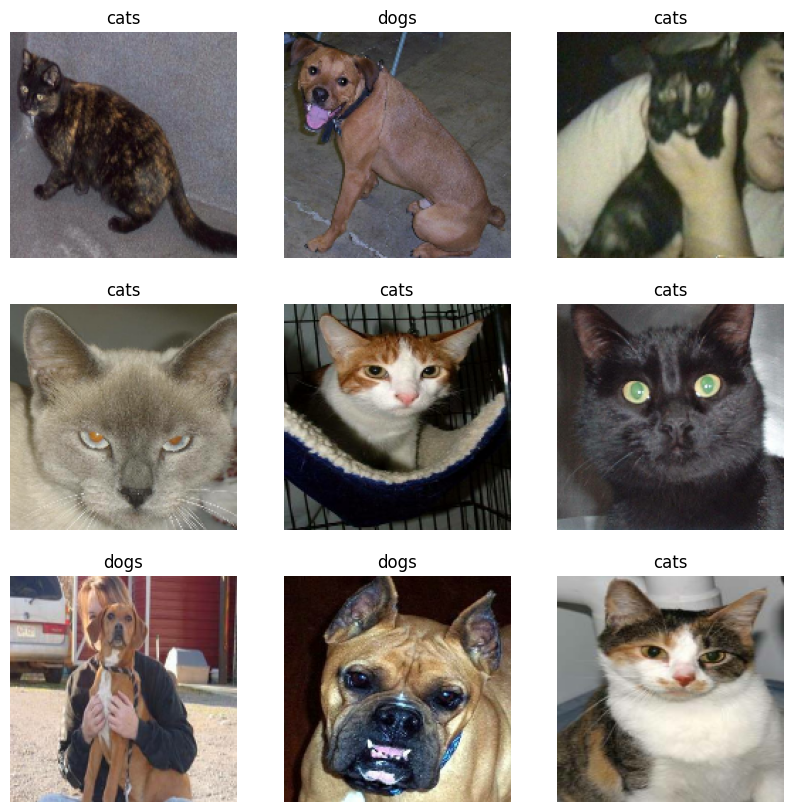

In [6]:
#Visualizando algumas amostras do dataset
class_names = train_dataset.class_names
plt.figure(figsize = (10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential(
  [
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(2.0)
  ]   
)

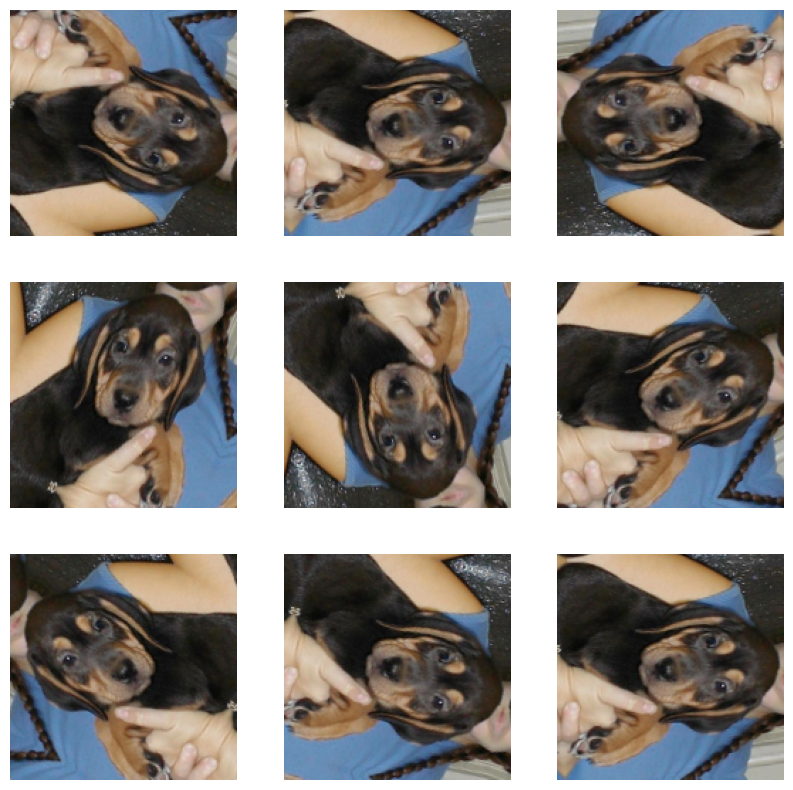

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize = (10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
rescale = tf.keras.layers.Rescaling(1./127.5, offset = -1)

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet'
)

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [14]:
#Extração de recursos
base_model.trainable = False

In [ ]:
#Visualizando arquitetura do modelo base
base_model.summary()

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch)

In [18]:
inputs = tf.keras.Input(shape = (160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [26]:
initial_epochs = 10

In [27]:
history = model.fit(
    train_dataset,
    epochs = initial_epochs,
    validation_data = validation_dataset
)

Epoch 1/10
213/213 [==============================] - 18s 62ms/step - loss: 0.5956 - accuracy: 0.6729 - val_loss: 0.3373 - val_accuracy: 0.8217
Epoch 2/10
213/213 [==============================] - 11s 50ms/step - loss: 0.4022 - accuracy: 0.8106 - val_loss: 0.2158 - val_accuracy: 0.9058
Epoch 3/10
213/213 [==============================] - 11s 51ms/step - loss: 0.3280 - accuracy: 0.8458 - val_loss: 0.1653 - val_accuracy: 0.9350
Epoch 4/10
213/213 [==============================] - 13s 59ms/step - loss: 0.2884 - accuracy: 0.8677 - val_loss: 0.1387 - val_accuracy: 0.9467
Epoch 5/10
213/213 [==============================] - 11s 50ms/step - loss: 0.2733 - accuracy: 0.8758 - val_loss: 0.1218 - val_accuracy: 0.9583
Epoch 6/10
213/213 [==============================] - 12s 54ms/step - loss: 0.2516 - accuracy: 0.8866 - val_loss: 0.1112 - val_accuracy: 0.9608
Epoch 7/10
213/213 [==============================] - 10s 45ms/step - loss: 0.2437 - accuracy: 0.8926 - val_loss: 0.1020 - val_accuracy:

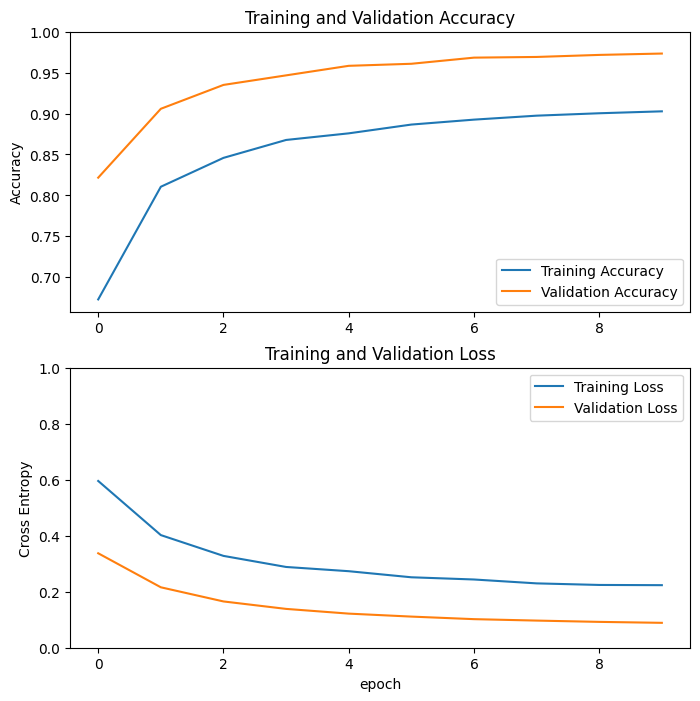

In [28]:
#Curvas de aprendizado
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
#Visualizando números de camada do modelo base
print("Number of layers in the base model: ", len(base_model.layers))

#Ajuste fino desta camada em diante
fine_tune_at = 100

#Congele todas as camadas antes da camada "fine_tune_at"
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = ['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
len(model.trainable_variables)

56

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
213/213 [==============================] - 25s 60ms/step - loss: 0.1921 - accuracy: 0.9214 - val_loss: 0.0665 - val_accuracy: 0.9750
Epoch 11/20
213/213 [==============================] - 12s 53ms/step - loss: 0.1626 - accuracy: 0.9323 - val_loss: 0.0497 - val_accuracy: 0.9817
Epoch 12/20
213/213 [==============================] - 12s 54ms/step - loss: 0.1536 - accuracy: 0.9387 - val_loss: 0.0467 - val_accuracy: 0.9800
Epoch 13/20
213/213 [==============================] - 12s 55ms/step - loss: 0.1432 - accuracy: 0.9428 - val_loss: 0.0484 - val_accuracy: 0.9808
Epoch 14/20
213/213 [==============================] - 12s 55ms/step - loss: 0.1322 - accuracy: 0.9431 - val_loss: 0.0495 - val_accuracy: 0.9800
Epoch 15/20
213/213 [==============================] - 12s 55ms/step - loss: 0.1161 - accuracy: 0.9522 - val_loss: 0.0501 - val_accuracy: 0.9808
Epoch 16/20
213/213 [==============================] - 12s 55ms/step - loss: 0.1125 - accuracy: 0.9544 - val_loss: 0.0523 - val_ac

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

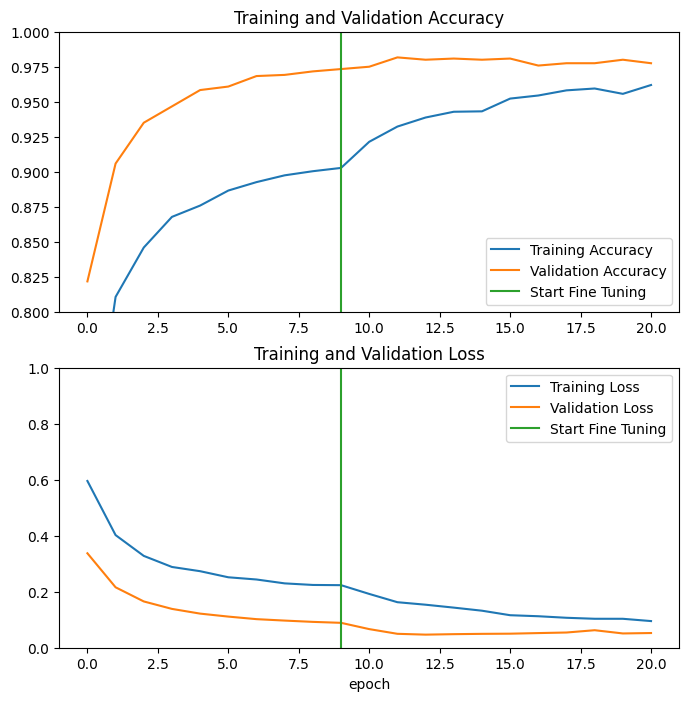

In [39]:
plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
loss, accuracy = model.evaluate(test_dataset)
print(accuracy)

64/64 [==============================] - 3s 43ms/step - loss: 0.0453 - accuracy: 0.9842
0.9841818809509277


Predictions:
 [0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1]
Labels:
 [0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1]


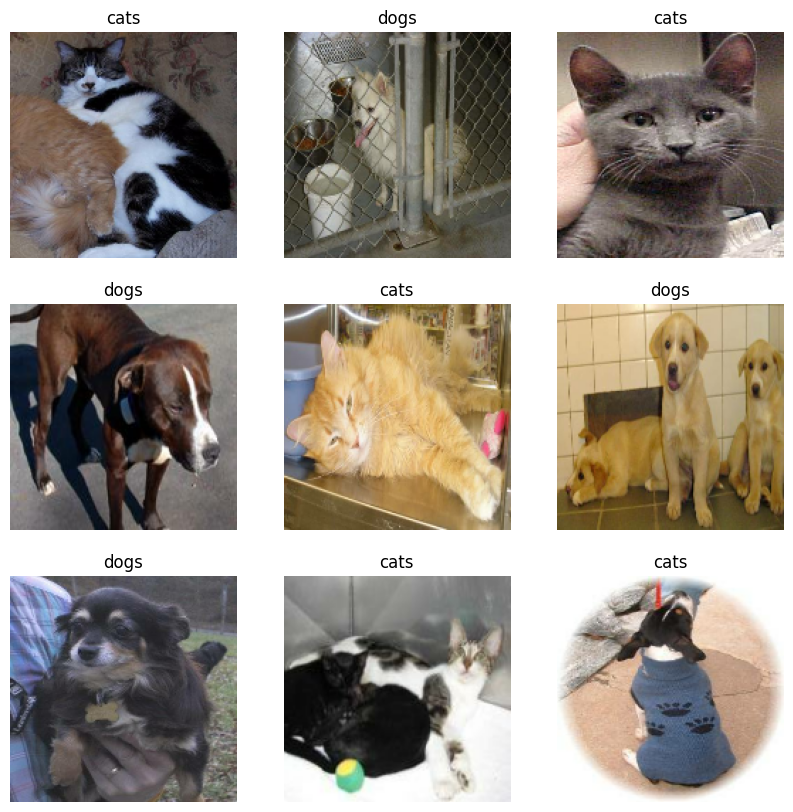

In [42]:
#Recupera um lote de imagens do conjunto de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

#Aplica uma função sigmoide. O modelo retorna dados em logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")